# Weeks 7 and 8. Machine learning

## Part 2. Clustering
In this notebook, you'll learn to apply clustering algorithms to classify data. We'll also do more work on mapping.

## Why cluster?
Cluster analysis is an exploratory technique to identify sensible groupings in a dataset. The analyst has no prior knowledge of what these clusters are, and the data are not labeled with the "correct" cluster. Thus, cluster analysis is an *unsupervised* machine learning technique.

Some potential applications of clustering:
* Identify types of Marine Protected Area (e.g., [Bohorquez et al. 2019](https://www.sciencedirect.com/science/article/pii/S0308597X19304439))
* Identify types of street networks (e.g., [Barrington-Leigh and Millard-Ball 2020](https://www.pnas.org/content/117/4/1941))
* Identify types of neighborhood (e.g., [Kendig 2007](https://www.tandfonline.com/doi/abs/10.1080/01944367608977731))
* Identify types of transit agencies (e.g. [Ederer et al. 2019](https://journals.sagepub.com/doi/full/10.1177/0361198119852074)

<img src="https://www.pnas.org/content/pnas/117/4/1941/F4.large.jpg" style="width:50%;"/>


Clustering the data in this way can help you see regularities in the data that you can then interpret. It might suggest policies that are appropriate for one group of cities or agencies but not another. Or it could identify a peer group against which to benchmark (say) affordable housing construction costs or transit on-time performance.

## Types of clustering
Formally, clustering takes a set of *N* objects and finds *K* groups based on a measure of similarity. For a technical yet accessible overview, I recommend [Jain 2010](https://www.sciencedirect.com/science/article/abs/pii/S0167865509002323). 

The two broad groups of clustering algorithms are *hierarchical* and *partitional*. 

Ederer et al. (2019), for example, use a hierarchical algorithm to classify transit agencies.

<img src="https://journals.sagepub.com/na101/home/literatum/publisher/sage/journals/content/trra/2019/trra_2673_11/0361198119852074/20191218/images/medium/10.1177_0361198119852074-fig1.gif" style="width:50%;"/>


But let's start with a partitional algorithm. The most popular is called *k-means*. Again, this is an exploratory data analysis process. The analyst needs to specify the number of clusters *K*, and should experiment with different values of *K* until a meaningful grouping emerges. Another way to choose *K* is the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), but we won't discuss that here.

## Example: precinct-level voting
We'll use the `sklearn` library to implement the k-means algorithm. The aim: identify a typology of voters based on precinct-level data.

The California [Statewide Database](https://statewidedatabase.org), maintained by UC Berkeley, provides access to voting data. Your GitHub repository should include the November 2020 precinct data for Los Angeles County.

In [1]:
%config Completer.use_jedi = False
import pandas as pd

# You might need to add a path as well
fn = 'c037_g20_sov_data_by_g20_srprec.csv'
df = pd.read_csv(fn)
df.head()

county    srprec  addist  cddist  sddist  bedist  TOTREG  DEMREG  REPREG  \
0      19  0050005A      36      25      21       1    1974       0       0   
1      19  0050014A      36      25      21       1     697       0       0   
2      19  0050022A      36      27      25       1      61       0       0   
3      19  0050024A      41      27      25       1       0       0       0   
4      19  0050025A      36      25      25       1       5       0       0   

   AIPREG  ...  PR_23_Y  PR_24_N  PR_24_Y  PR_25_N  PR_25_Y  SENAIP01  \
0       0  ...      430      945      771     1304      398         0   
1       0  ...      100      314      223      427      116         0   
2       0  ...       10       27       22       35       15         0   
3       0  ...        0        0        0        0        0         0   
4       0  ...        1        2        3        1        3         0   

   SENDEM01  SENDEM02  SENLIB01  SENREP01  
0       524         0         0      1197  
1       163         0         0       373  
2        20         0         0        33  
3         0         0         0         0  
4         2         0         0         3  

[5 rows x 73 columns]

In [2]:
# let's set the index as srprec, which is the unique identifier
df.set_index('srprec', inplace=True)
df.index.is_unique  # verify that it's unique

True

In [3]:
df.columns

Index(['county', 'addist', 'cddist', 'sddist', 'bedist', 'TOTREG', 'DEMREG',
       'REPREG', 'AIPREG', 'GRNREG', 'LIBREG', 'NLPREG', 'REFREG', 'DCLREG',
       'MSCREG', 'TOTVOTE', 'DEMVOTE', 'REPVOTE', 'AIPVOTE', 'GRNVOTE',
       'LIBVOTE', 'NLPVOTE', 'REFVOTE', 'DCLVOTE', 'MSCVOTE', 'PRCVOTE',
       'ABSVOTE', 'ASSDEM01', 'ASSDEM02', 'ASSGRN01', 'ASSIND01', 'ASSLIB01',
       'ASSREP01', 'ASSREP02', 'CNGDEM01', 'CNGDEM02', 'CNGREP01', 'PRSAIP01',
       'PRSDEM01', 'PRSGRN01', 'PRSLIB01', 'PRSPAF01', 'PRSREP01', 'PR_14_N',
       'PR_14_Y', 'PR_15_N', 'PR_15_Y', 'PR_16_N', 'PR_16_Y', 'PR_17_N',
       'PR_17_Y', 'PR_18_N', 'PR_18_Y', 'PR_19_N', 'PR_19_Y', 'PR_20_N',
       'PR_20_Y', 'PR_21_N', 'PR_21_Y', 'PR_22_N', 'PR_22_Y', 'PR_23_N',
       'PR_23_Y', 'PR_24_N', 'PR_24_Y', 'PR_25_N', 'PR_25_Y', 'SENAIP01',
       'SENDEM01', 'SENDEM02', 'SENLIB01', 'SENREP01'],
      dtype='object')

There are obviously a lot of columns. You can see the [full codebook here](https://statewidedatabase.org/d10/g20.html). But the propositions are pretty self explanatory. `PRSDEM01` gives votes for Biden, `PRSREP01` for Trump, etc. Note the state Senate and Assembly races will be different depending on the precinct, so let's ignore those.

First, we see that the numbers are in absolute terms. Let's convert them to vote share.

In [4]:
# this is share of two-party vote (ignoring other candidates)
df['Biden_pc'] = df.PRSDEM01 / (df.PRSDEM01+df.PRSREP01)*100

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Loop over each proposition and create a "percentage yes" column for each.
</div>

In [5]:
# solution
import numpy as np

# split the relevant columns on '_' and take the second (index 1) element
props = [col.split('_')[1] for col in df.columns if col.startswith('PR_')]

# remove duplicates
props = np.unique(props)
print(props)

for prop in props:
    df[prop+'_pc_yes'] = df['PR_'+prop+'_Y'] / (df['PR_'+prop+'_Y']+df['PR_'+prop+'_N'])*100


['14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25']


In [6]:
df.head()

county  addist  cddist  sddist  bedist  TOTREG  DEMREG  REPREG  \
srprec                                                                     
0050005A      19      36      25      21       1    1974       0       0   
0050014A      19      36      25      21       1     697       0       0   
0050022A      19      36      27      25       1      61       0       0   
0050024A      19      41      27      25       1       0       0       0   
0050025A      19      36      25      25       1       5       0       0   

          AIPREG  GRNREG  ...  16_pc_yes  17_pc_yes  18_pc_yes  19_pc_yes  \
srprec                    ...                                               
0050005A       0       0  ...  20.081019  33.865450  22.165242  36.484919   
0050014A       0       0  ...  18.081181  32.783883  20.292505  35.140187   
0050022A       0       0  ...  27.272727  41.509434  25.925926  43.396226   
0050024A       0       0  ...        NaN        NaN        NaN        NaN   
0050025A       0       0  ...  40.000000  40.000000  20.000000  75.000000   

          20_pc_yes  21_pc_yes  22_pc_yes  23_pc_yes  24_pc_yes  25_pc_yes  
srprec                                                                      
0050005A  50.058275  22.344748  69.155093  25.087515  44.930070  23.384254  
0050014A  51.201479  19.038817  70.985401  18.518519  41.527002  21.362799  
0050022A  42.307692  22.641509  75.000000  18.867925  44.897959  30.000000  
0050024A        NaN        NaN        NaN        NaN        NaN        NaN  
0050025A  20.000000   0.000000  60.000000  20.000000  60.000000  75.000000  

[5 rows x 85 columns]

### Inspect and standardize the data

Number 1 rule: before applying any algorithm to your data, look at it!

We could create a scatterplot matrix manually. But `seaborn` has a [nice function to do this for us](https://seaborn.pydata.org/examples/scatterplot_matrix.html).

In [7]:
import seaborn as sns

help(sns.pairplot)

Help on function pairplot in module seaborn.axisgrid:

pairplot(data, *, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)
    Plot pairwise relationships in a dataset.
    
    By default, this function will create a grid of Axes such that each numeric
    variable in ``data`` will by shared across the y-axes across a single row and
    the x-axes across a single column. The diagonal plots are treated
    differently: a univariate distribution plot is drawn to show the marginal
    distribution of the data in each column.
    
    It is also possible to show a subset of variables or plot different
    variables on the rows and columns.
    
    This is a high-level interface for :class:`PairGrid` that is intended to
    make it easy to draw a few common styles. You should use :class:`PairGrid`
    directly 

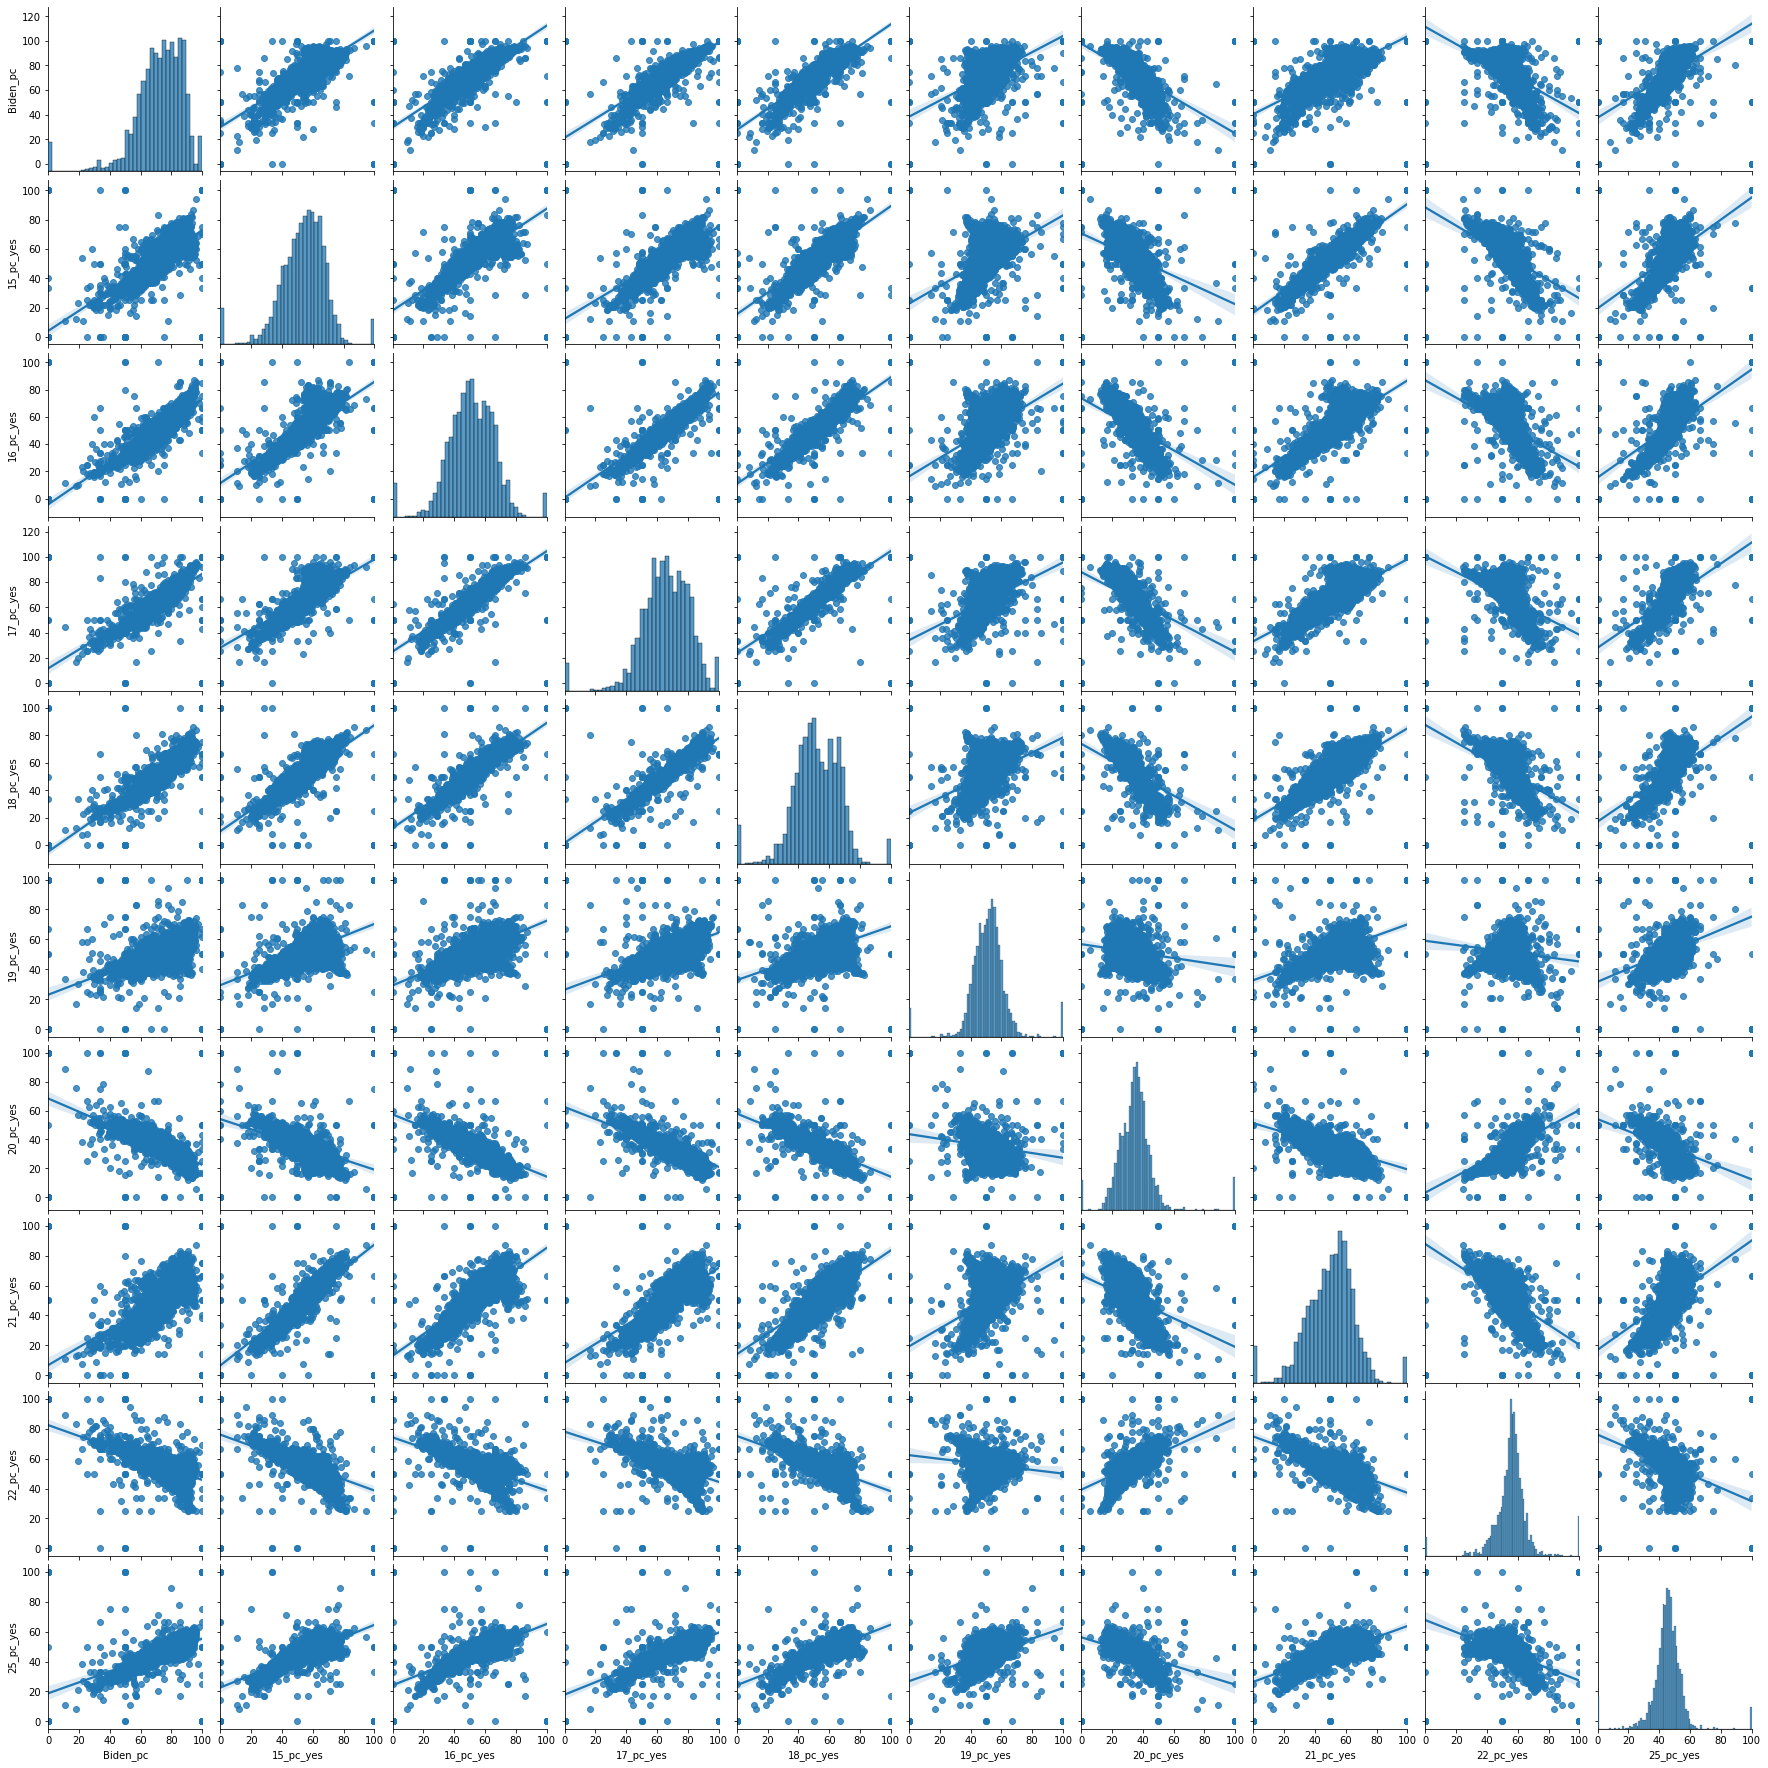

In [8]:
# plot a subset of the columns
# Let's also ignore a few of the less sweeping propositions
# Should stem cell research and dialysis rules really be on the ballot?
cols_to_plot = [col for col in df.columns if '_pc' in col]
cols_to_plot = [col for col in cols_to_plot if '14' not in col and '23' not in col and '24' not in col]

ax = sns.pairplot(df[cols_to_plot], kind='reg')  # kind='reg' adds the line of best fit

There are pretty strong relationships between Presidential voting and the propositions. All have a positive correlation except for Prop 20 (harsher sentencing) and Prop 22 (independent contractor status for drivers for Uber, Doordash, etc.). [A helpful reminder of the propositions is here](independent contractors).

But there isn't a perfect relationship. Perhaps cluster analysis can reveal some groupings?

First, it helps to pre-process the data in two ways:
* Let's align the data so that a higher percent means more progressive. This means using the percent "no" for Props 20 and 22
* We should standardize each variable to mean zero and standard deviation one. This helps ensure that the distances in multidimensional space are consistent. (Since we have a percentage measure, it won't make much difference compared to a variable like population, but it's good practice.)

In [9]:
for prop in ['20','22']:
    df[prop+'_pc_no'] = 100 - df[prop+'_pc_yes']
    df.drop(columns=[prop+'_pc_yes'], inplace=True)

cols_to_plot = [col.replace('yes','no') if '20' in col or '22' in col else col for col in cols_to_plot ]
df.head()

# see https://scikit-learn.org/stable/modules/preprocessing.html for standardization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df[cols_to_plot])

# the scaler returns a numpy array, so we cast this as a DataFrame and need to specify the column names and index
df_scaled = pd.DataFrame(scaler.transform(df[cols_to_plot]), columns=cols_to_plot, index=df.index)

Let's check that our data still look reasonable by rerunning the same pairplot.

Notice that the y axes run from about -3 to +3. This should be true for any standardized variable, as most observations are within 3 standard deviations of the mean.

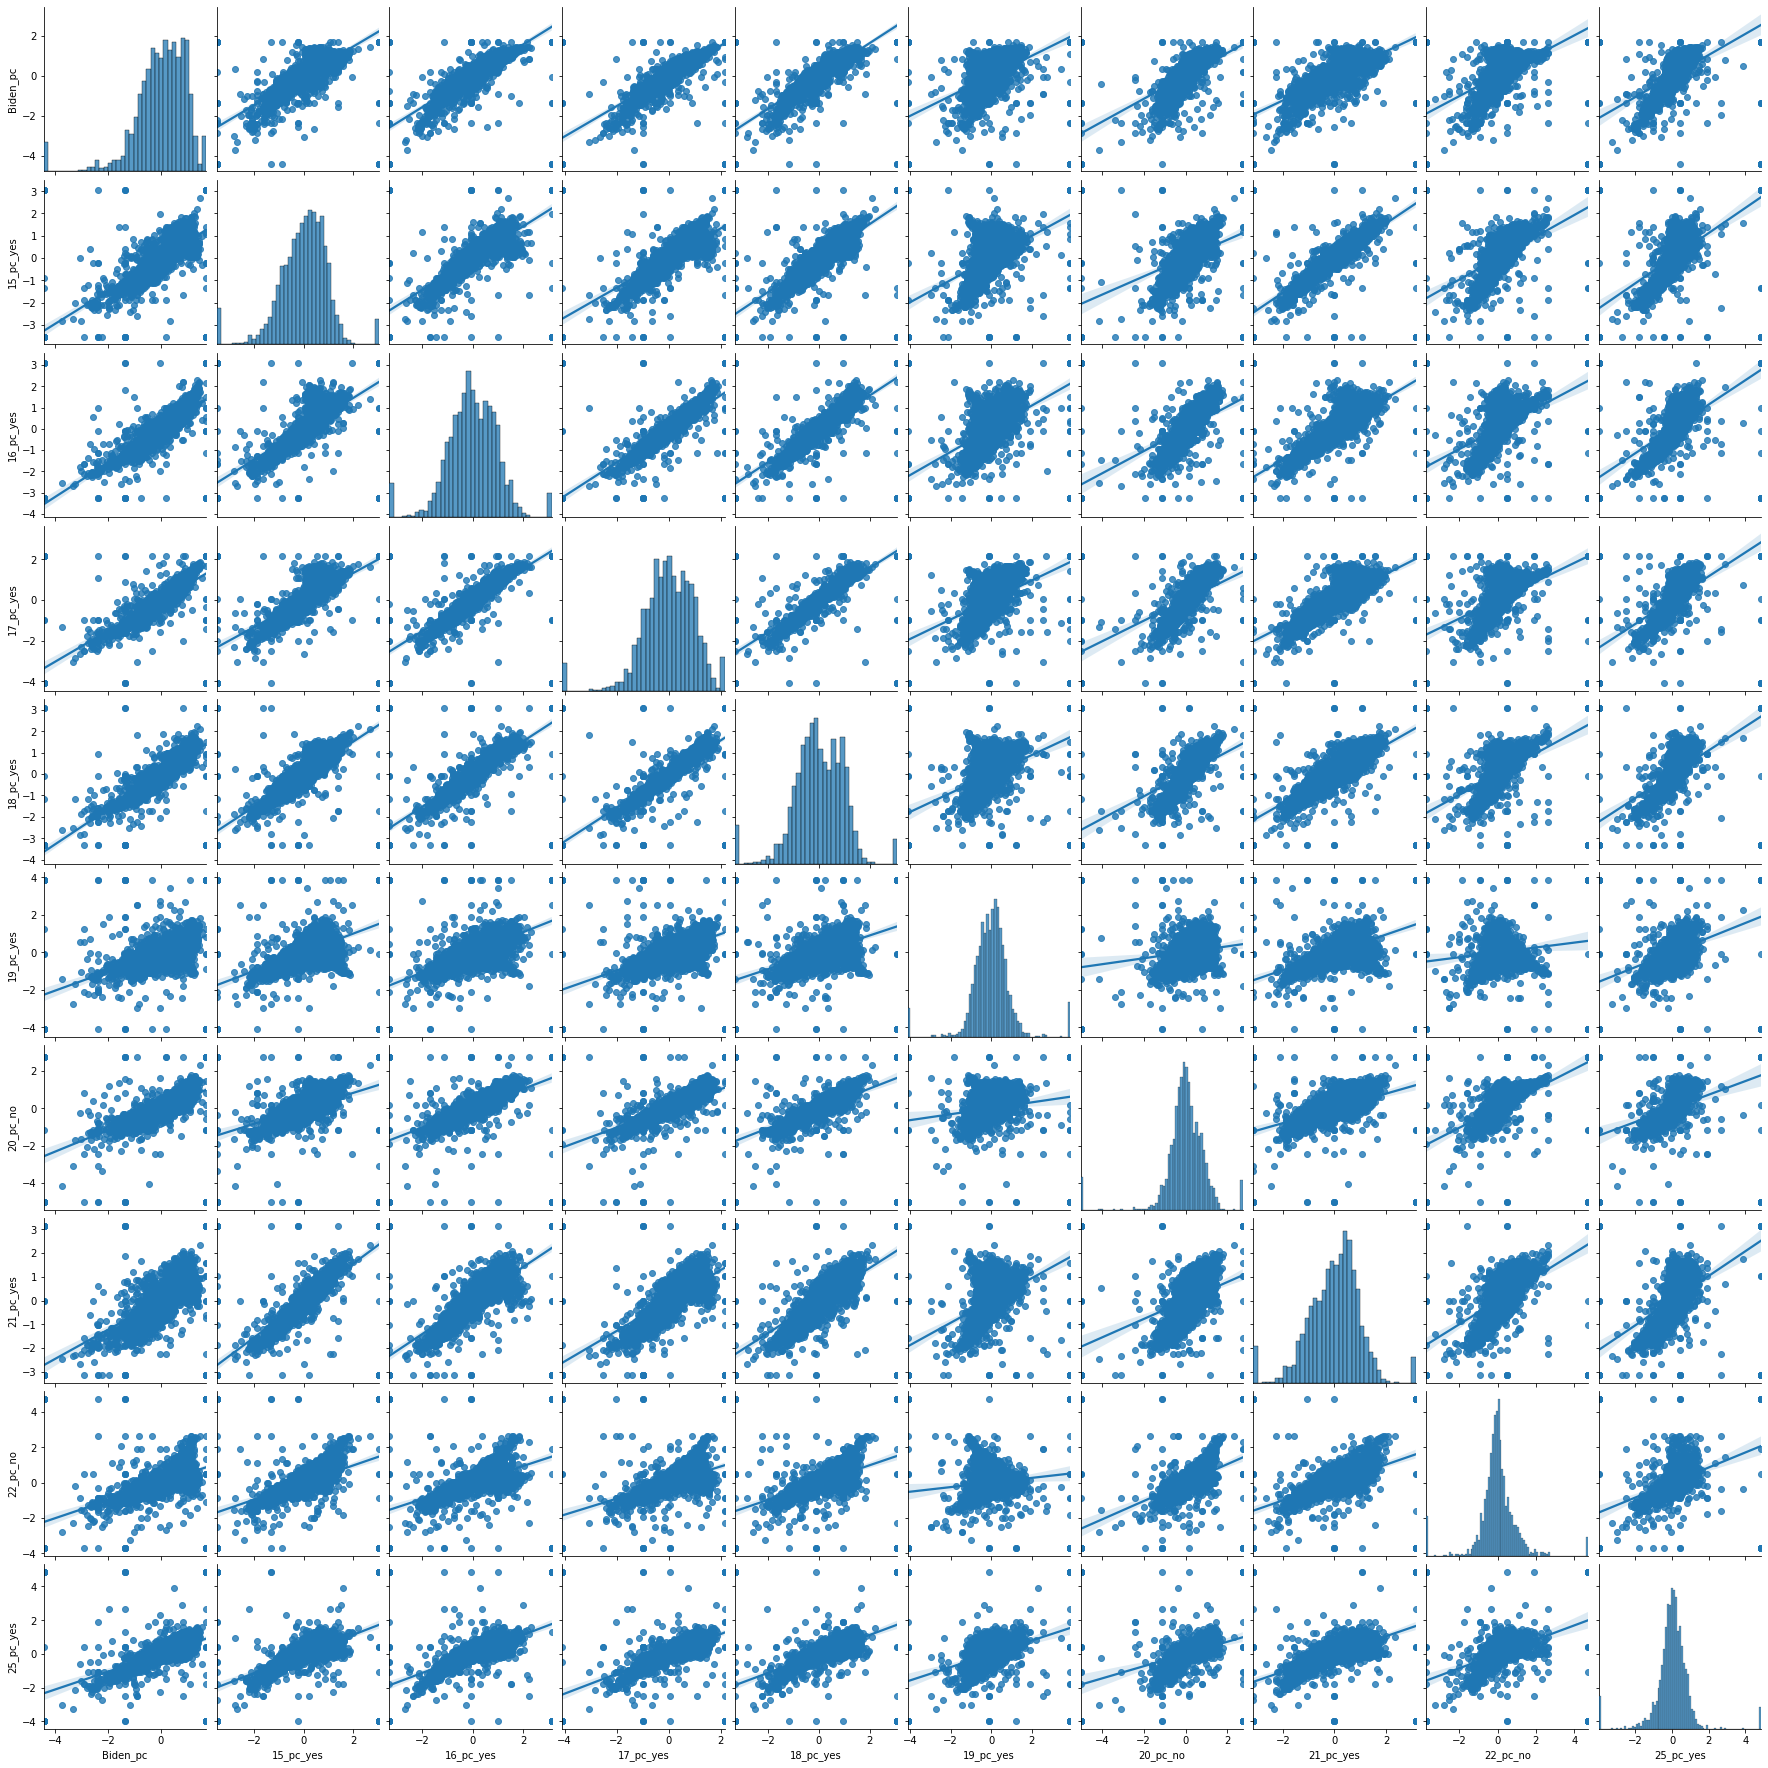

In [10]:
ax = sns.pairplot(df_scaled, kind='reg')

### KMeans in scikit-learn

In [68]:
from sklearn.cluster import KMeans
help(KMeans) # look at the examples for the syntax

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` o

In [69]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_scaled)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<div class="alert alert-block alert-info">
We got an error. How should we fix it?</div>

In [70]:
df_scaled = df_scaled.dropna()
kmeans = KMeans(n_clusters=5).fit(df_scaled)

In [71]:
print(kmeans)

KMeans(n_clusters=5)


It's not immediately obvious what we can do with this `KMeans` object. But let's explore it.

In [72]:
kmeans.cluster_centers_

array([[-0.39637739, -0.47046513, -0.49246244, -0.46993469, -0.48213832,
        -0.2837457 , -0.28813344, -0.47980774, -0.25269321, -0.25646576],
       [ 0.88898809,  0.89187034,  1.02595437,  0.98593938,  1.04247503,
         0.44285323,  0.71700918,  0.8462755 ,  0.62849294,  0.662479  ],
       [ 0.27197651,  0.2835489 ,  0.1885114 ,  0.18440722,  0.13987536,
         0.3276629 ,  0.08412684,  0.31768858,  0.11603288,  0.1668031 ],
       [-1.33807399, -1.29276015, -1.30568913, -1.28348588, -1.31389353,
        -0.87488858, -0.81041798, -1.30468159, -0.79605981, -0.94786846],
       [-4.14735076, -3.27988948, -3.12701801, -3.061108  , -3.06569169,
        -2.7174734 , -3.21084094, -2.6678734 , -3.61112607, -3.44913461]])

In [73]:
kmeans.labels_

array([3, 3, 3, ..., 0, 4, 2], dtype=int32)

Notice that the `cluster_centers_` is an array that is `K x L`, where `K` is the number of clusters and `L` is the number of variables.

In [74]:
print(kmeans.cluster_centers_.shape)
print(len(df_scaled.columns))

(5, 10)
10


Now, the `labels_` object assigns each row in your dataframe (i.e., each precinct), to a cluster.

In [75]:
print(kmeans.labels_.shape)
print(len(df_scaled))

(3082,)
3082


So we can simply add the cluster id back to our original dataframe!

In [77]:
df_scaled['cluster_id'] = kmeans.labels_

<ipython-input-77-f5f12d4037d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['cluster_id'] = kmeans.labels_


How large is each cluster? Note that the algorithm doesn't aim to produce equal-size groupings.

In [78]:
df_scaled.groupby('cluster_id').size()

cluster_id
0    858
1    888
2    892
3    412
4     32
dtype: int64

### Visualizing the clusters
How best to visualize what the clusters mean? If we had just two columns, a scatterplot with a color code for each cluster would work well. But we have 13 dimensions.

One way is to redo our original scatter plot matrix, but with each cluster indicated.

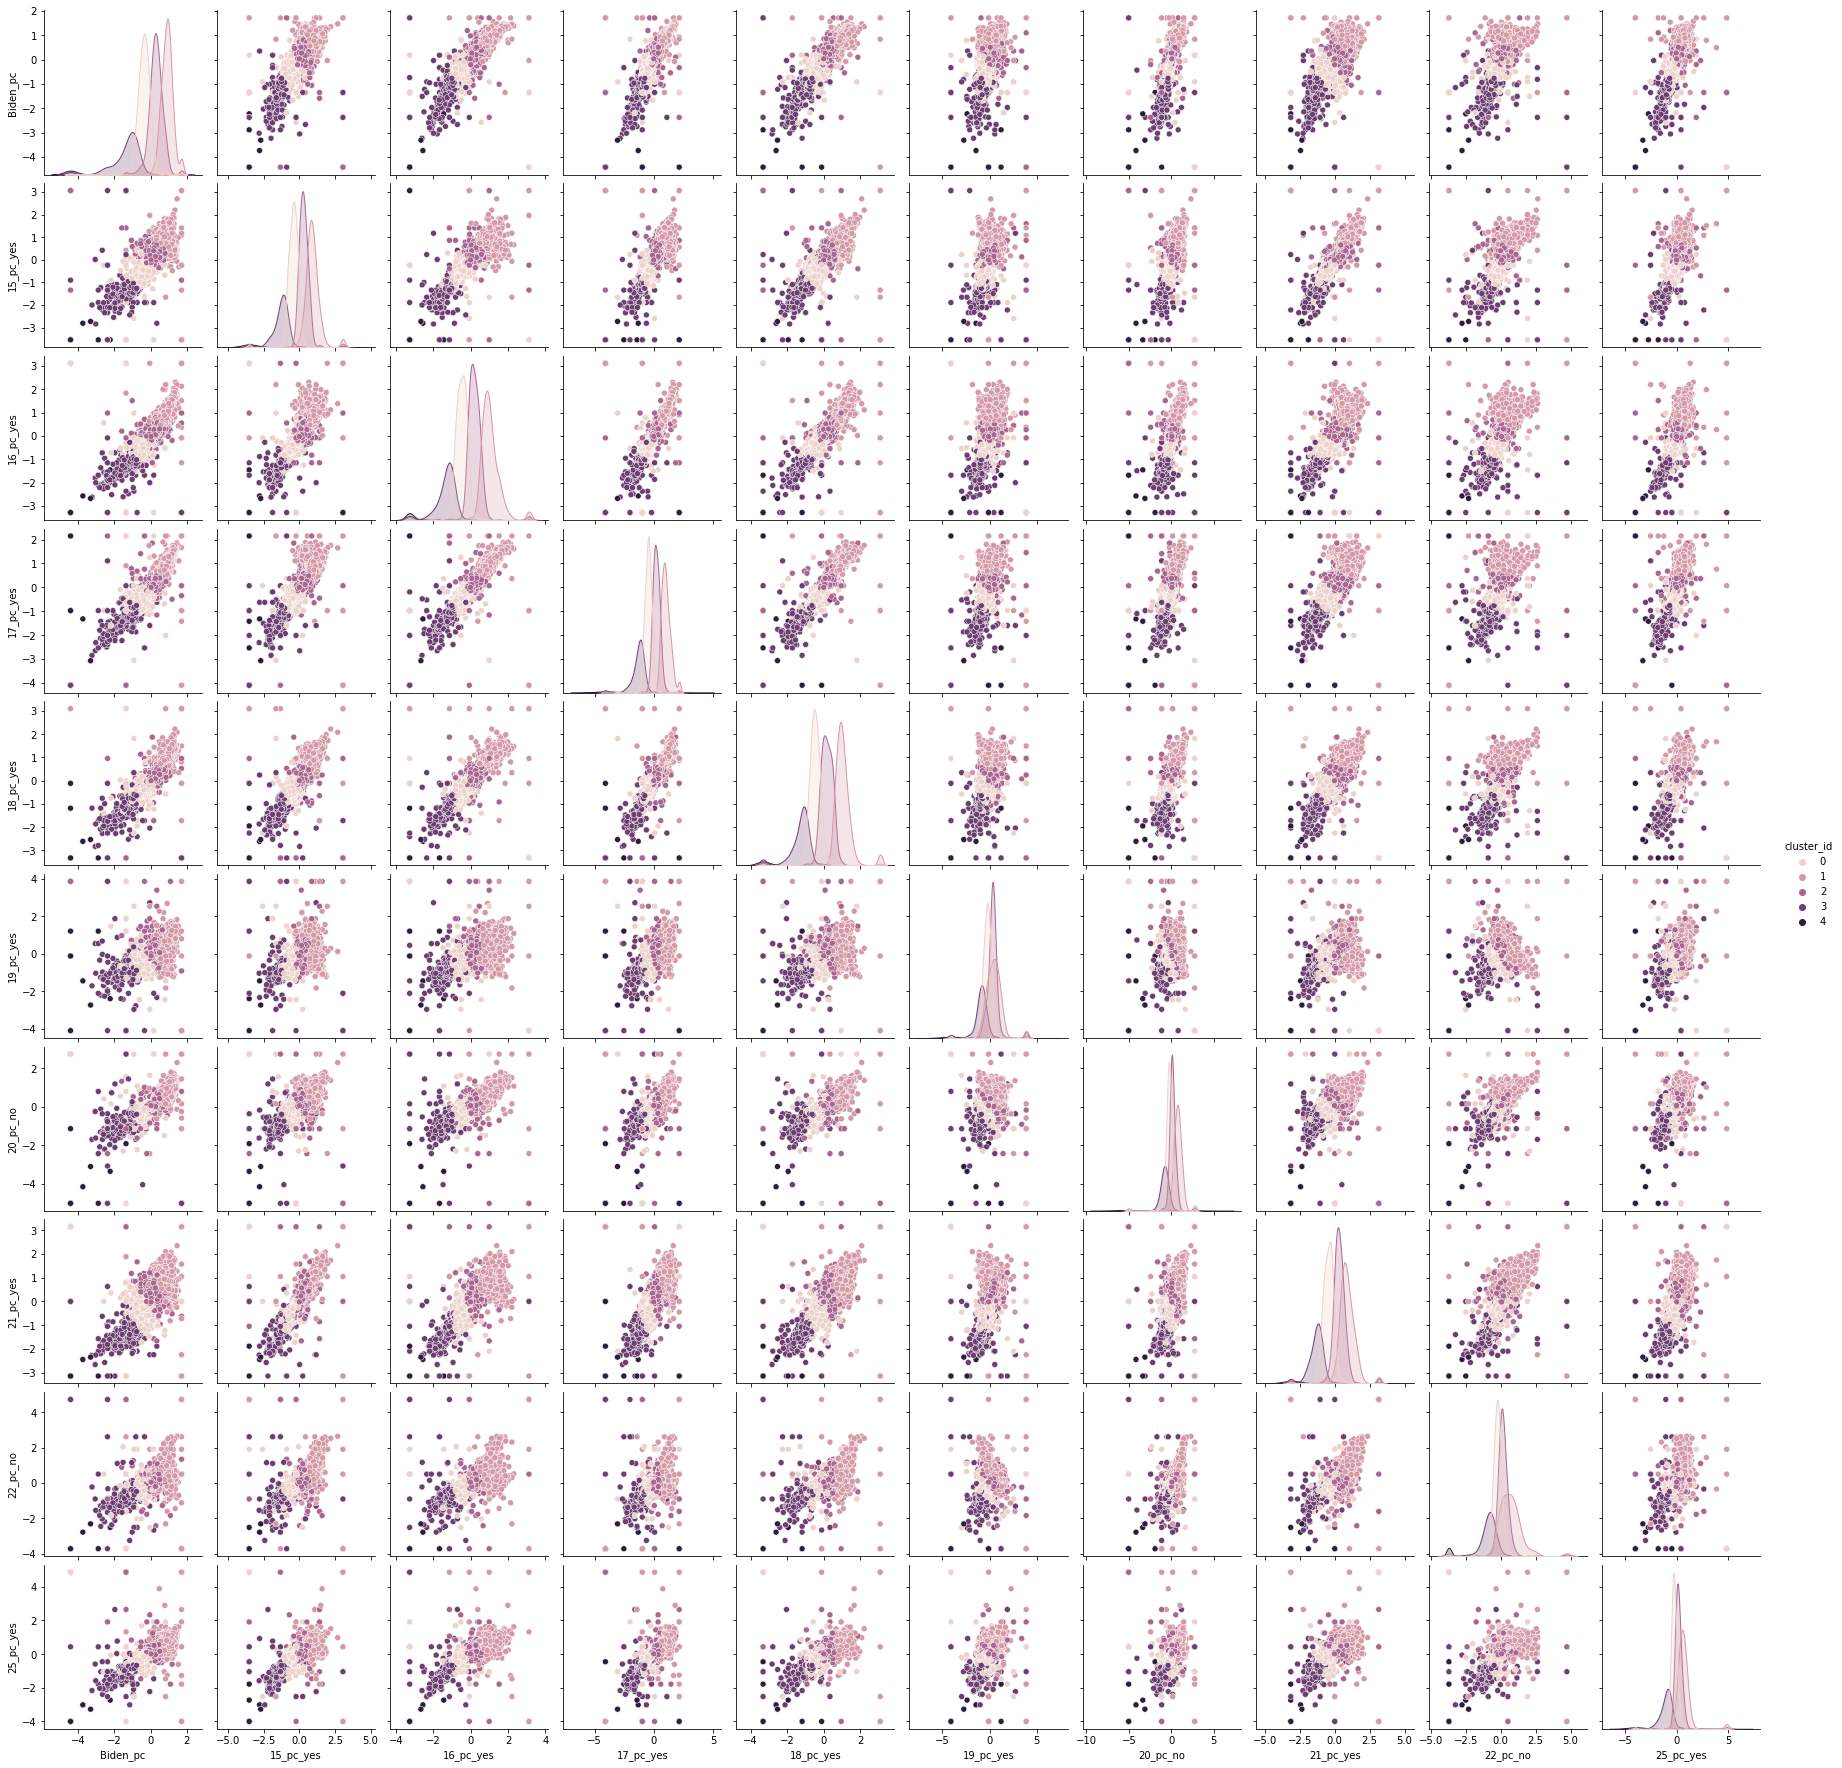

In [79]:
ax = sns.pairplot(df_scaled, hue='cluster_id', )

My preferred option, however, is a radar chart. Neither `seaborn` nor `matplotlib` do this natively, but [there is an example in the `matplotlib` gallery](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html). I've just copied and pasted that code.

In [80]:
# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


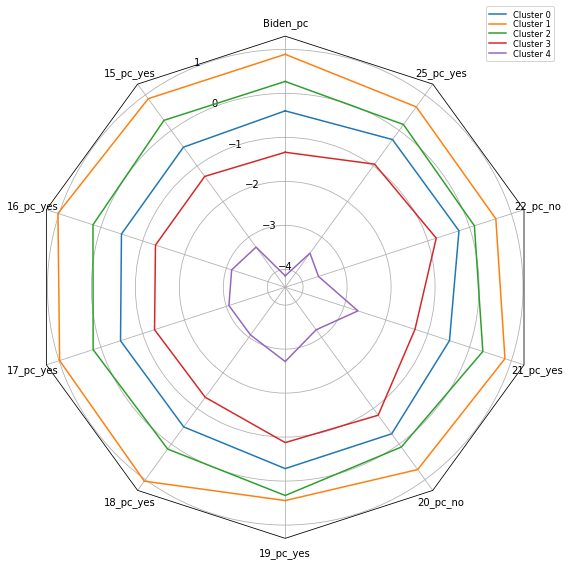

In [81]:
# adapting the example
%matplotlib inline

# let's put this in a function so we can call it easily again
def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


    #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    #        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
    #                     horizontalalignment='center', verticalalignment='center')
    #        for d, color in zip(case_data, colors):
    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

radar_plot(kmeans, df_scaled)


### Exploring different numbers of clusters
Here, the interesting finding is that all the clusters form concentric circles. There isn't a cluster of precincts that (say) votes against rent control but is progressive on the other items on the ballot.

We can certainly find these clusters if we increase `k`, but then these "weird" clusters have few precincts.

/Users/adammb/anaconda3/envs/urbandatascience/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-84-f08289f6ab64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['cluster_id'] = kmeans.labels_


cluster_id
0    357
1    581
2     31
3    892
4    747
5    425
6     10
7     13
8     10
9     16
dtype: int64


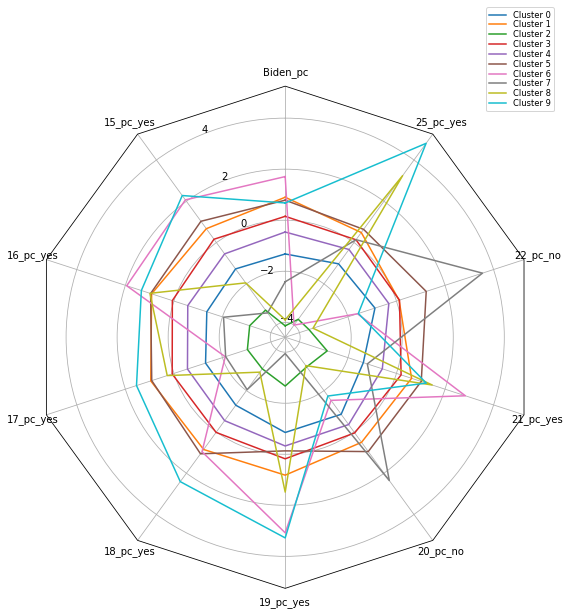

In [84]:
df_scaled.drop(columns=['cluster_id'], inplace=True)   # we don't want to include the old cluster id in our new estimates
kmeans = KMeans(n_clusters=10).fit(df_scaled)
df_scaled['cluster_id'] = kmeans.labels_
print(df_scaled.groupby('cluster_id').size())
radar_plot(kmeans, df_scaled)

/Users/adammb/anaconda3/envs/urbandatascience/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-85-324687c30998>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['cluster_id'] = kmeans.labels_


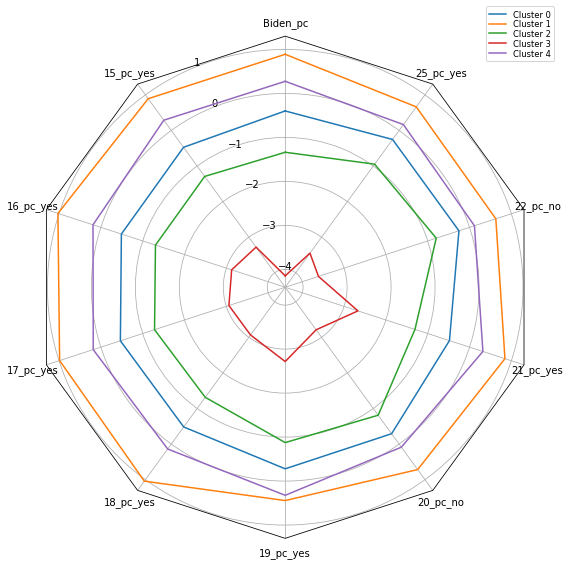

In [85]:
# let's go back to our original 4 clusters
# we might notice that the cluster centroids have changed a bit
# this is because the algorithm is not deterministic
# if we want to be able to reproduce, we can pass the random_state keyword argument
df_scaled.drop(columns=['cluster_id'], inplace=True)   # we don't want to include the old cluster id in our new estimates
kmeans = KMeans(n_clusters=5, random_state=1).fit(df_scaled)
df_scaled['cluster_id'] = kmeans.labels_
radar_plot(kmeans, df_scaled)

### Mapping the clusters
The Statewide Database team provide geographic boundary files as well as the vote counts. The shapefile is in your GitHub respository.

In [86]:
import geopandas as gpd

gdf = gpd.read_file('srprec_037_g20_v01_shp/srprec_037_g20_v01.shp')  # you might need to adjust the path
gdf.head()

# note that there is no projection file, so geopandas doesn't know the coordinate system
print(gdf.crs)

# the docs say it's in lat/lon
gdf.crs = 'EPSG:4326'

None


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Join the cluster id to the GeoDataFrame and map the clusters.
</div>

In [87]:
# solution
# first, look at the data to figure out what type of join we expect
print(df_scaled.head())
print(len(gdf))
print(len(df_scaled))
print(df_scaled.index.is_unique)
print(gdf.SRPREC.is_unique)

          Biden_pc  15_pc_yes  16_pc_yes  17_pc_yes  18_pc_yes  19_pc_yes  \
srprec                                                                      
0050005A -2.392682  -1.915590  -1.991738  -1.979115  -1.899401  -1.191242   
0050014A -2.395257  -2.194086  -2.119545  -2.046594  -2.019681  -1.298507   
0050022A -2.033142  -2.539322  -1.532125  -1.502205  -1.657865  -0.639951   
0050025A -1.965086  -2.216013  -0.718741  -1.596379  -2.038468   1.880973   
0050026A -4.415092  -3.534119  -3.275091  -4.091990  -3.323004  -4.101518   

          20_pc_no  21_pc_yes  22_pc_no  25_pc_yes  cluster_id  
srprec                                                          
0050005A -1.145504  -1.740321 -1.113734  -1.925904           2  
0050014A -1.234295  -1.948547 -1.268524  -2.105159           2  
0050022A -0.543531  -1.721629 -1.608039  -1.339247           2  
0050025A  1.189066  -3.147720 -0.339487   2.651168           2  
0050026A  2.742429  -3.147720  4.734721   4.868065           2  
3383


In [88]:
# If we join on srprec, it looks like we can do a 1:1 join since both columns are unique
# If we do a left join from gdf, we'll have some missing data but that's OK

# rename the column so both are lowercase
gdf.rename(columns={'SRPREC':'srprec'}, inplace=True)
gdf.set_index('srprec', inplace=True)
joinedGdf = gdf.join(df_scaled)
joinedGdf.head()

geometry  Biden_pc  \
srprec                                                                  
0050005A  POLYGON ((-118.18916 34.47138, -118.18969 34.4... -2.392682   
0050014A  MULTIPOLYGON (((-118.17087 34.47532, -118.1711... -2.395257   
0050022A  POLYGON ((-118.04978 34.38108, -118.05005 34.3... -2.033142   
0050024A  POLYGON ((-118.09634 34.37991, -118.09644 34.3...       NaN   
0050025A  POLYGON ((-118.21436 34.42330, -118.21286 34.4... -1.965086   

          15_pc_yes  16_pc_yes  17_pc_yes  18_pc_yes  19_pc_yes  20_pc_no  \
srprec                                                                      
0050005A  -1.915590  -1.991738  -1.979115  -1.899401  -1.191242 -1.145504   
0050014A  -2.194086  -2.119545  -2.046594  -2.019681  -1.298507 -1.234295   
0050022A  -2.539322  -1.532125  -1.502205  -1.657865  -0.639951 -0.543531   
0050024A        NaN        NaN        NaN        NaN        NaN       NaN   
0050025A  -2.216013  -0.718741  -1.596379  -2.038468   1.880973  1.189066   

          21_pc_yes  22_pc_no  25_pc_yes  cluster_id  
srprec                                                
0050005A  -1.740321 -1.113734  -1.925904         2.0  
0050014A  -1.948547 -1.268524  -2.105159         2.0  
0050022A  -1.721629 -1.608039  -1.339247         2.0  
0050024A        NaN       NaN        NaN         NaN  
0050025A  -3.147720 -0.339487   2.651168         2.0

Text(0.5, 1.0, 'Typology of voting, 2020 General Election')

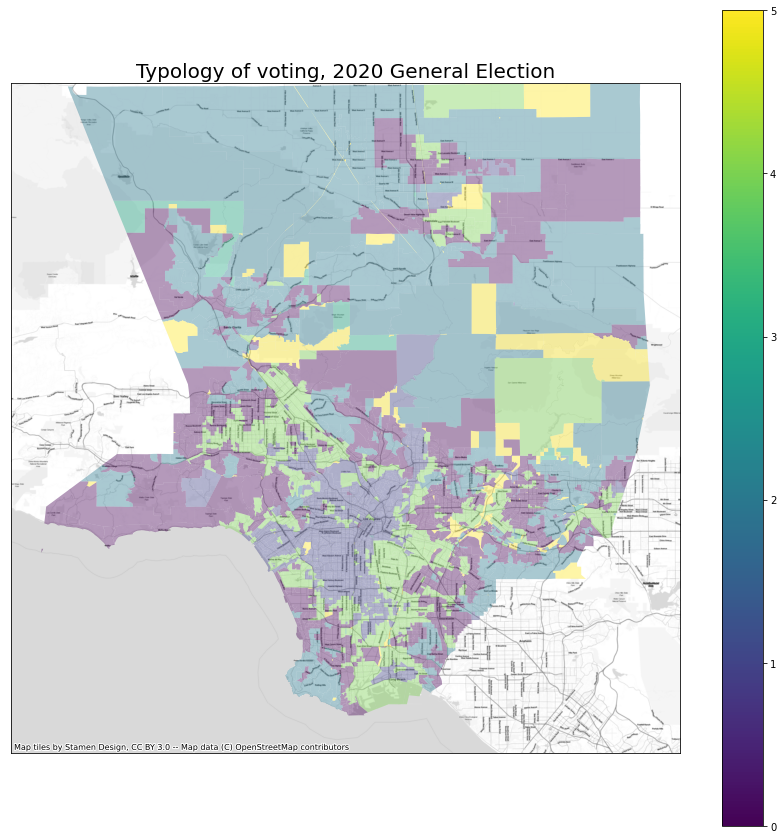

In [89]:
# now let's map. We should color code by cluster_id

import contextily as ctx
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))

# replace the missing values with cluster 5
joinedGdf.cluster_id.fillna(5, inplace=True)

joinedGdf.to_crs('EPSG:3857').plot('cluster_id', legend=True, ax = ax, alpha=0.4)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)

# drop Catalina
ax.set_ylim([3.98e6, 4.14e6])

# and we really don't need the axis ticks and labels, so we set them to an empty list
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Typology of voting, 2020 General Election', fontsize=20)

Let's unpack the map a bit more. 

First, note the `alpha` keyword. This controls the transparency, so that the basemap comes through.

The `source` keyword gives access to lots of options. Take a look at the possibilities with `ctx.providers`.

In [90]:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/tiles/osmde/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'attribution': '(C) Openstreetmap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by 

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> How else would you improve the map?
</div>

[]

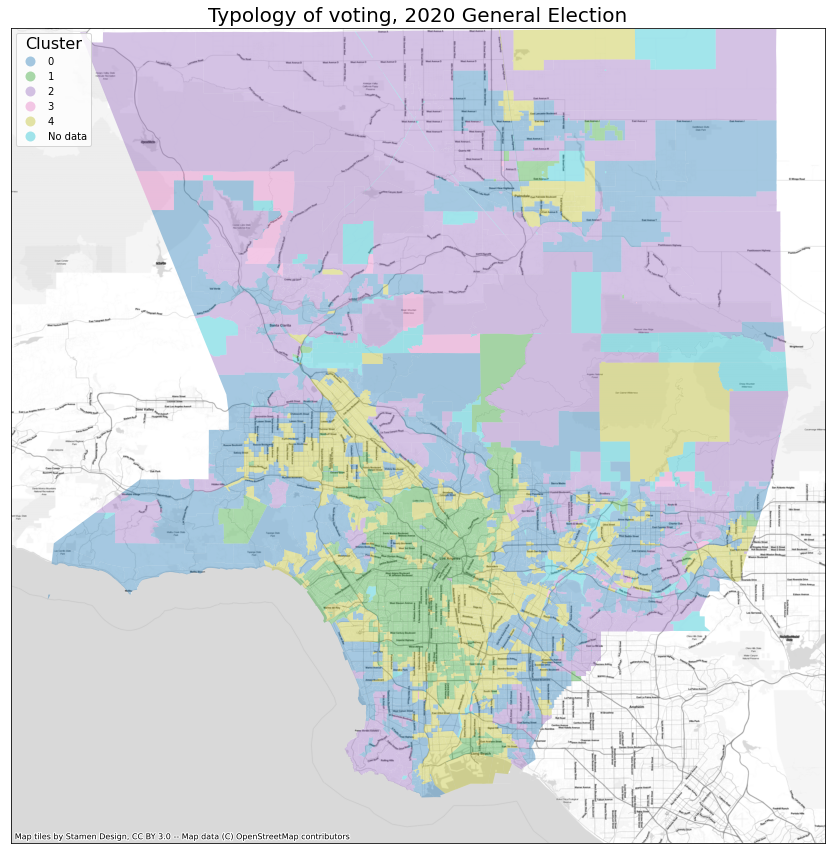

In [175]:
# solution
# There's no right answer here, but I would do some of the following

# Give the clusters better names
joinedGdf.cluster_id = joinedGdf.cluster_id.astype(int).astype(str)
joinedGdf.loc[joinedGdf.cluster_id=='5','cluster_id'] = 'No data'

# replace the colorbar with a legend. 
# This is because we have discrete categories (0-5), not a continuous variable
# use the categorical=True keyword argument

fig, ax = plt.subplots(figsize=(15,15))
joinedGdf.to_crs('EPSG:3857').plot('cluster_id', ax=ax, categorical=True, legend=True, alpha=0.4,
                                  legend_kwds={'loc': 'upper left'})

# also useful to add a legend title
legend = ax.get_legend()
legend.set_title("Cluster", prop={'size':16} )

# all this is the same as before
ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Typology of voting, 2020 General Election', fontsize=20)                           
ax.set_ylim([3.98e6, 4.14e6])
ax.set_xticks([])
ax.set_yticks([])

[]

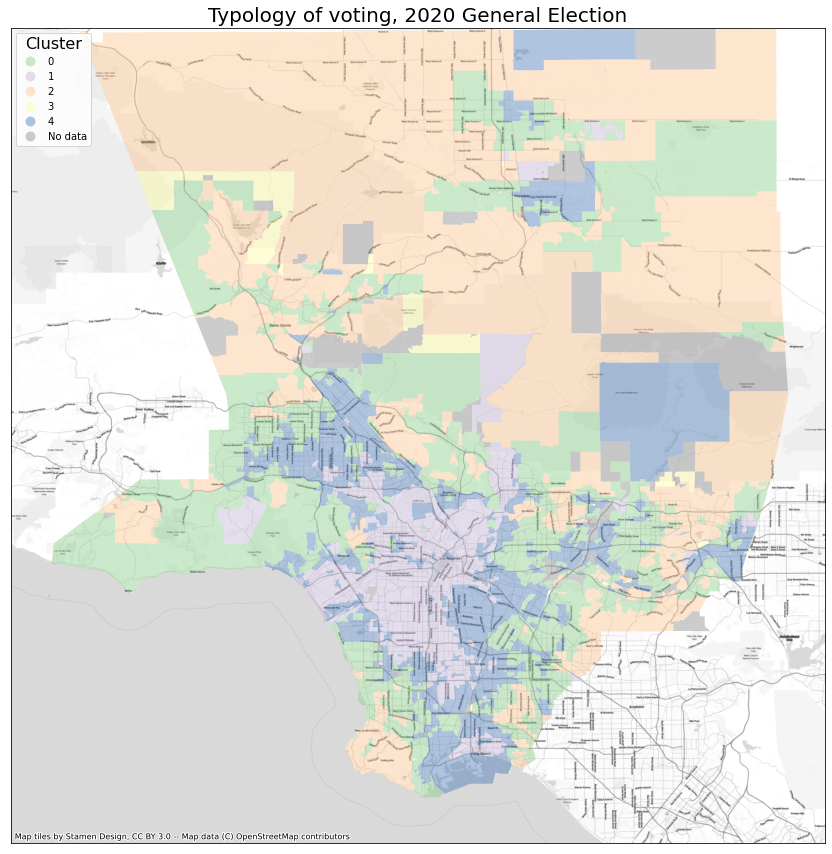

In [176]:
# specify the colors. I find https://colorbrewer2.org the most helpful
# we should make sure cluster 5 is grey (missing data), which we represent as a string between 0 and 1
# this is 5 qualitative colors

# getting the colors into a colormap required some searching
# https://stackoverflow.com/questions/38882233/geopandas-matplotlib-plot-custom-colors
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#7fc97f'), (0.2, '#beaed4'), (0.4, '#fdc086'), 
               (0.6, '#ffff99'), (0.8, '#386cb0'), (1.0, '0.5')])

fig, ax = plt.subplots(figsize=(15,15))
joinedGdf.to_crs('EPSG:3857').plot('cluster_id', cmap=cmap, categorical=True, legend=True, ax=ax, alpha=0.4,
                                                                     legend_kwds={'loc': 'upper left'})


# all this is the same as before
legend = ax.get_legend()
legend.set_title("Cluster", prop={'size':16} )

ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Typology of voting, 2020 General Election', fontsize=20)                           
ax.set_ylim([3.98e6, 4.14e6])
ax.set_xticks([])
ax.set_yticks([])

## Spatial clustering
The same principles apply to identify clusters in space. The difference: we just cluster on the `x` and `y` coordinates rather than non-spatial variables such as voting on a particular proposition.

Let's look at [clusters of marijuana dispensaries](https://data.lacity.org/Administration-Finance/Medical-Marijuana-Collective-Map/rv73-2zf4) in LA.

In [15]:
import requests
import json
url = 'https://data.lacity.org/resource/rv73-2zf4.json'
r = requests.get(url)
mdf = pd.DataFrame(json.loads(r.content))
mdf.head()

zip_code :@computed_region_qz3q_ghft :@computed_region_k96s_3jcv  \
0  91356-6320                       19339                         320   
1  94601-2803                         NaN                         NaN   
2  90023-3915                       23441                         528   
3  90272-2124                       25066                         835   
4  91311-6101                        4279                         102   

   mailing_city               city :@computed_region_kqwf_mjcx  \
0  SHERMAN OAKS            TARZANA                           4   
1           NaN            OAKLAND                         NaN   
2   WESTBOROUGH        LOS ANGELES                           9   
3           NaN  PACIFIC PALISADES                          10   
4       NEWHALL         CHATSWORTH                           4   

                    business_name :@computed_region_2dna_qi2s   naics  \
0                       I'M A KID                          10  888888   
1  STRATEGIC STAR PROPERTIES INC.                         NaN  888888   
2          HOLISTIC ESPERANZA LLC                          38  888888   
3                     AFROZE BARI                         NaN  888888   
4             SACRED TREE 365 LLC                          66  888888   

      primary_naics_description  ... :@computed_region_tatf_ua23  \
0  Medical Marijuana Collective  ...                        1496   
1  Medical Marijuana Collective  ...                         NaN   
2  Medical Marijuana Collective  ...                        1269   
3  Medical Marijuana Collective  ...                        1526   
4  Medical Marijuana Collective  ...                        1542   

                      street_address :@computed_region_ur2y_g4cx  \
0  5420   YOLANDA AVENUE   UNIT #125                           6   
1        2960 CHAPMAN STREET UNIT #2                         NaN   
2              1500 ESPERANZA STREET                         NaN   
3             1387 AVENIDA DE CORTEZ                         NaN   
4                20660 BAHAMA STREET                         NaN   

  mailing_zip_code      location_start_date                   mailing_address  \
0       91423-4236  2020-09-21T00:00:00.000  14100   DICKENS STREET   UNIT #1   
1              NaN  2018-01-01T00:00:00.000                               NaN   
2       01581-3942  2020-11-01T00:00:00.000                 1900 W PARK DRIVE   
3              NaN  2020-12-08T00:00:00.000                               NaN   
4       91321-3810  2018-01-01T00:00:00.000        23601 WILDWOOD CANYON ROAD   

    location_account council_district  \
0  0003240374-0001-7                3   
1  0003239654-0001-3                0   
2  0003226875-0001-3               14   
3  0003223752-0001-2               11   
4  0003218503-0001-2                3   

                                          location_1             dba_name  
0  {'latitude': '34.1694', 'human_address': '{"ad...                  NaN  
1                                                NaN                  NaN  
2  {'latitude': '34.0155', 'human_address': '{"ad...  HOLISTIC INDUSTRIES  
3  {'latitude': '34.0722', 'human_address': '{"ad...                  NaN  
4  {'latitude': '34.2314', 'human_address': '{"ad...                  NaN  

[5 rows x 21 columns]

Note the lat /lon information is a dictionary in the `location_1` column. So we can extract that from a dictionary and add it to new columns

In [16]:
mdf.location_1.iloc[0]

{'latitude': '34.1694',
 'human_address': '{"address": "", "city": "", "state": "", "zip": ""}',
 'needs_recoding': False,
 'longitude': '-118.54'}

In [50]:
mdf['lat'] = mdf.location_1.apply(lambda x: float(x['latitude']) if isinstance(x, dict) else None)
mdf['lon'] = mdf.location_1.apply(lambda x: float(x['longitude']) if isinstance(x, dict) else None)

# exclude null values and very crudely limit to LA
# I eyeballed these lat/lon limits from a map
mdf = mdf[pd.notnull(mdf.lat)]
mdf = mdf[(mdf.lat>=33.6) & (mdf.lat<=34.8)]
mdf = mdf[(mdf.lon>=-119.0) & (mdf.lon<=-117.6)]


mgdf = gpd.GeoDataFrame(mdf, 
            geometry = gpd.points_from_xy(mdf.lon, mdf.lat), 
            crs='EPSG:4326')
mgdf.head()

zip_code :@computed_region_qz3q_ghft :@computed_region_k96s_3jcv  \
0  91356-6320                       19339                         320   
2  90023-3915                       23441                         528   
3  90272-2124                       25066                         835   
4  91311-6101                        4279                         102   
5  91402-6313                       19730                         138   

   mailing_city               city :@computed_region_kqwf_mjcx  \
0  SHERMAN OAKS            TARZANA                           4   
2   WESTBOROUGH        LOS ANGELES                           9   
3           NaN  PACIFIC PALISADES                          10   
4       NEWHALL         CHATSWORTH                           4   
5           NaN      PANORAMA CITY                           3   

            business_name :@computed_region_2dna_qi2s   naics  \
0               I'M A KID                          10  888888   
2  HOLISTIC ESPERANZA LLC                          38  888888   
3             AFROZE BARI                         NaN  888888   
4     SACRED TREE 365 LLC                          66  888888   
5       JOSELITO SANTIAGO                          59  888888   

      primary_naics_description  ...      location_start_date  \
0  Medical Marijuana Collective  ...  2020-09-21T00:00:00.000   
2  Medical Marijuana Collective  ...  2020-11-01T00:00:00.000   
3  Medical Marijuana Collective  ...  2020-12-08T00:00:00.000   
4  Medical Marijuana Collective  ...  2018-01-01T00:00:00.000   
5  Medical Marijuana Collective  ...  2016-01-01T00:00:00.000   

                    mailing_address   location_account council_district  \
0  14100   DICKENS STREET   UNIT #1  0003240374-0001-7                3   
2                 1900 W PARK DRIVE  0003226875-0001-3               14   
3                               NaN  0003223752-0001-2               11   
4        23601 WILDWOOD CANYON ROAD  0003218503-0001-2                3   
5                               NaN  0003217121-0001-1                6   

                                          location_1             dba_name  \
0  {'latitude': '34.1694', 'human_address': '{"ad...                  NaN   
2  {'latitude': '34.0155', 'human_address': '{"ad...  HOLISTIC INDUSTRIES   
3  {'latitude': '34.0722', 'human_address': '{"ad...                  NaN   
4  {'latitude': '34.2314', 'human_address': '{"ad...                  NaN   
5  {'latitude': '34.2168', 'human_address': '{"ad...                  NaN   

       lat       lon                     geometry cluster_id  
0  34.1694 -118.5400  POINT (-118.54000 34.16940)          6  
2  34.0155 -118.2006  POINT (-118.20060 34.01550)         18  
3  34.0722 -118.5624  POINT (-118.56240 34.07220)          6  
4  34.2314 -118.5838  POINT (-118.58380 34.23140)         12  
5  34.2168 -118.4284  POINT (-118.42840 34.21680)         19  

[5 rows x 25 columns]

Now let's cluster. Again, we'd want to experiment with `K`, but let's identify 20 clusters to start.

Technically, we should reproject before we cluster because a degree of latitude is not the same distance as a degree of longitude. But we can overlook that for simplicity's sake.

In [57]:
kmeans = KMeans(n_clusters=20, random_state=1).fit(mgdf[['lat','lon']])
mgdf['cluster_id'] = kmeans.labels_
mgdf.head()

zip_code :@computed_region_qz3q_ghft :@computed_region_k96s_3jcv  \
0  91356-6320                       19339                         320   
2  90023-3915                       23441                         528   
3  90272-2124                       25066                         835   
4  91311-6101                        4279                         102   
5  91402-6313                       19730                         138   

   mailing_city               city :@computed_region_kqwf_mjcx  \
0  SHERMAN OAKS            TARZANA                           4   
2   WESTBOROUGH        LOS ANGELES                           9   
3           NaN  PACIFIC PALISADES                          10   
4       NEWHALL         CHATSWORTH                           4   
5           NaN      PANORAMA CITY                           3   

            business_name :@computed_region_2dna_qi2s   naics  \
0               I'M A KID                          10  888888   
2  HOLISTIC ESPERANZA LLC                          38  888888   
3             AFROZE BARI                         NaN  888888   
4     SACRED TREE 365 LLC                          66  888888   
5       JOSELITO SANTIAGO                          59  888888   

      primary_naics_description  ...      location_start_date  \
0  Medical Marijuana Collective  ...  2020-09-21T00:00:00.000   
2  Medical Marijuana Collective  ...  2020-11-01T00:00:00.000   
3  Medical Marijuana Collective  ...  2020-12-08T00:00:00.000   
4  Medical Marijuana Collective  ...  2018-01-01T00:00:00.000   
5  Medical Marijuana Collective  ...  2016-01-01T00:00:00.000   

                    mailing_address   location_account council_district  \
0  14100   DICKENS STREET   UNIT #1  0003240374-0001-7                3   
2                 1900 W PARK DRIVE  0003226875-0001-3               14   
3                               NaN  0003223752-0001-2               11   
4        23601 WILDWOOD CANYON ROAD  0003218503-0001-2                3   
5                               NaN  0003217121-0001-1                6   

                                          location_1             dba_name  \
0  {'latitude': '34.1694', 'human_address': '{"ad...                  NaN   
2  {'latitude': '34.0155', 'human_address': '{"ad...  HOLISTIC INDUSTRIES   
3  {'latitude': '34.0722', 'human_address': '{"ad...                  NaN   
4  {'latitude': '34.2314', 'human_address': '{"ad...                  NaN   
5  {'latitude': '34.2168', 'human_address': '{"ad...                  NaN   

       lat       lon                     geometry cluster_id  
0  34.1694 -118.5400  POINT (-118.54000 34.16940)         13  
2  34.0155 -118.2006  POINT (-118.20060 34.01550)          5  
3  34.0722 -118.5624  POINT (-118.56240 34.07220)         15  
4  34.2314 -118.5838  POINT (-118.58380 34.23140)          3  
5  34.2168 -118.4284  POINT (-118.42840 34.21680)          6  

[5 rows x 25 columns]

And map them! Again, this is almost identical code to what we used before. But let's ditch the legend because there are lots of clusters and the number is not as relevant.

[]

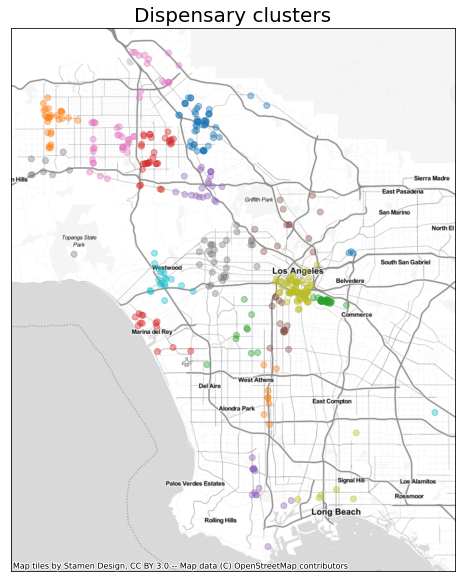

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
mgdf.to_crs('EPSG:3857').plot('cluster_id', categorical=True, legend=False, 
                                   ax=ax, alpha=0.4)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Dispensary clusters', fontsize=20)                           
#ax.set_ylim([3.98e6, 4.14e6])
ax.set_xticks([])
ax.set_yticks([])

We could also map the centroid of each cluster. But that's where we will leave things for now.

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Cluster analysis is an exploratory data tool</li>
  <li>Even if the clusters are pretty self-explanatory, they can be useful</li>
  <li>They are a general case of <em>data reduction</em>—reducing your data to something that can be readily intepreted</li>
  <li>They can be a starting point for further quantitative research—perhaps, use them as a variable in a regression model. </li>
  <li>They can also be useful for qualitative research. Perhaps you might do a case study of each cluster, picking the precinct/city/agency that is closest to each cluster center.</li>
</ul>
</div>